In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal
from edward.stats import norm
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


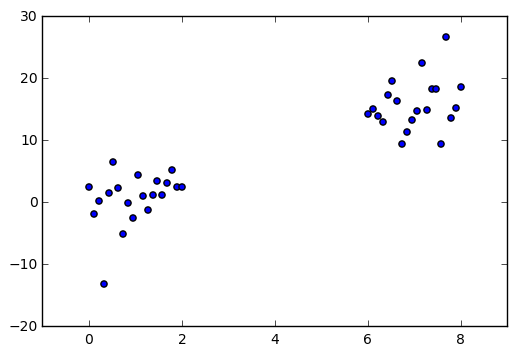

In [2]:
def build_toy_dataset(N, noise_std=0.5):
  X = np.concatenate([np.linspace(0, 2, num=N / 2),
                      np.linspace(6, 8, num=N / 2)])
  y = 2.0 * X + 10*norm.rvs(0, noise_std, size=N)
  X = X.reshape((N, 1))
  return X.astype(np.float32), y.astype(np.float32)

N = 40  # num data points
D = 1  # num features

# DATA
X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

plt.scatter(X_train, y_train);

In [3]:
# MODEL

# placeholder for the data
X = ed.placeholder(tf.float32, [N, D])

# priors on the latent variables
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

#likelihood of the data
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

In [4]:

# INFERENCE
qw = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

data = {X: X_train, y: y_train}
inference = ed.MFVI({w: qw, b: qb}, data)
inference.run()

Iteration    1 [  0%]: Loss = 5771.297
Iteration  100 [ 10%]: Loss = 415.719
Iteration  200 [ 20%]: Loss = 364.857
Iteration  300 [ 30%]: Loss = 351.418
Iteration  400 [ 40%]: Loss = 349.708
Iteration  500 [ 50%]: Loss = 353.584
Iteration  600 [ 60%]: Loss = 349.562
Iteration  700 [ 70%]: Loss = 353.292
Iteration  800 [ 80%]: Loss = 351.204
Iteration  900 [ 90%]: Loss = 351.408
Iteration 1000 [100%]: Loss = 351.151


In [5]:
# CRITICISM
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
# This is equivalent to
# y_post = Normal(mu=ed.dot(X, qw.mean()) + qb.mean(), sigma=tf.ones(N))

print("test mean squared error: {:.3f}".format(
        ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test})))


test mean squared error: 22.484


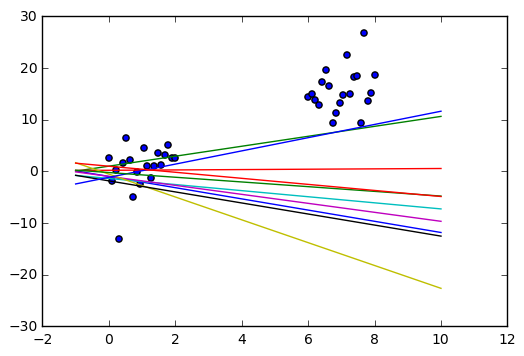

In [6]:
# samples from the prior
n_prior_samples = 10

w_prior = w.sample(n_prior_samples).eval()
b_prior = b.sample(n_prior_samples).eval()



plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
for ns in range(n_prior_samples):
    output = inputs*w_prior[ns] + b_prior[ns]
    plt.plot(inputs,output)

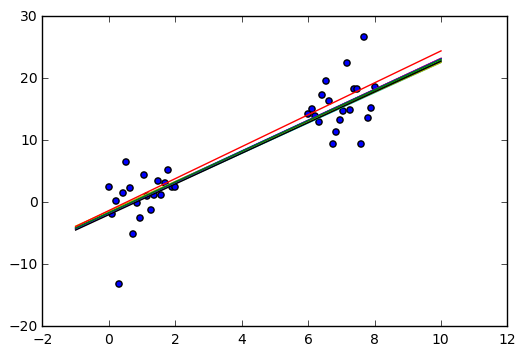

In [7]:
# samples from the posterior
n_posterior_samples = 10

w_post = qw.sample(n_posterior_samples).eval()
b_post = qb.sample(n_posterior_samples).eval()



plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
for ns in range(n_posterior_samples):
    output = inputs*w_post[ns] + b_post[ns]
    plt.plot(inputs,output)